# Livrable 1 - classification d'images

# Introduction
Voici notre démarche pour mettre en place un model de classification :

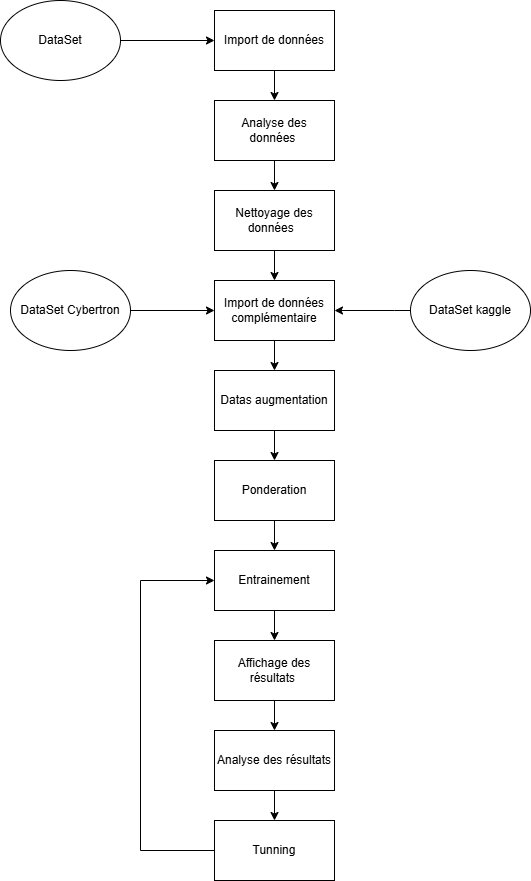

# Dépendances
Les dépandances nécessaires à la bonne exécution du code.

In [1]:
#Import des dépendances
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict
import shutil
import random
import kaggle
import requests
from zipfile import ZipFile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Initialisation

Extraction du dataset de base du projet. 

In [2]:
# Extraction du dataset
def extract_dataset(zip_path, extract_to):
    """
    Extrait les fichiers d'un dataset zippé.

    Args:
        zip_path (str): Chemin vers le fichier zip.
        extract_to (str): Dossier où extraire les fichiers.
    """
    # Convertir les chemins en chemins absolus pour éviter les erreurs
    zip_path = os.path.abspath(zip_path)
    extract_to = os.path.abspath(extract_to)

    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Le fichier {zip_path} n'existe pas.")
    
    # Si le dossier de destination existe, le supprimer
    if os.path.exists(extract_to):
        shutil.rmtree(extract_to)
        print(f"Le dossier existant {extract_to} a été supprimé.")

    os.makedirs(extract_to, exist_ok=True)

    with ZipFile(zip_path, 'r') as zip_ref:
        # zip_ref.extractall(extract_to)
        # Aplatir la structure du zip : extraire les fichiers directement dans extract_to
        for member in zip_ref.namelist():
            filename = os.path.basename(member)
            # Vérifie si c'est un fichier zip contenant 'Livrable 1' dans le nom
            if filename and filename.endswith('.zip') and 'Livrable 1' in filename:
                source = zip_ref.open(member)
                target_path = os.path.join(extract_to, filename)
                with source, open(target_path, "wb") as target:
                    target.write(source.read())
        

    # Extrait tout les sous zip du dossier extrait
    for root, dirs, files in os.walk(extract_to):
        for file in files:
            if file.endswith('.zip'):
                sub_zip_path = os.path.join(root, file)
                with ZipFile(sub_zip_path, 'r') as sub_zip_ref:
                    sub_zip_ref.extractall(root)
                os.remove(sub_zip_path)  # Supprime le zip après extraction
    
    print(f"Dataset extrait dans le dossier : {extract_to}")

In [3]:
# Appel de la fonction pour extraire le dataset
dataset_zip_path = './Dataset/Datasets.zip'
extract_dataset(dataset_zip_path, './Dataset/Dataset1')

Le dossier existant c:\Users\mallo\OneDrive\Bureau\CESI 2022 - 2025\Annee 5\Semestre 10\Option data science\Project\Data-science-project-A5\Dataset\Dataset1 a été supprimé.
Dataset extrait dans le dossier : c:\Users\mallo\OneDrive\Bureau\CESI 2022 - 2025\Annee 5\Semestre 10\Option data science\Project\Data-science-project-A5\Dataset\Dataset1


# Analyse du dataset
Dans cette partie, nous allons analyser le dataset afin d'identifier les actions nécessaires à son utilisation pour entraîner notre IA.

## Informations sur le dataset
Nous parcourons le dataset pour récupérer les différentes classes ainsi que le nombre de données (images) par classe.

Nous affichons ensuite un histogramme pour une meilleure visualisation.

In [4]:
# Chemin vers le dataset
dataset_path = "./Dataset/Dataset1" # Chemin vers le dataset

# Récupération des classes et du nombre d'images par classe
classes = []
image_counts = []
image_in_Sketch=0

In [5]:
def get_infos_datas(dataset_path):
    # Vérification de l'existence du dossier
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Le dossier {dataset_path} n'existe pas.")

    # Récupération des classes et du nombre d'images par classe
    classes = []
    image_counts = []

    # Parcours des fichiers dans le dataset
    for class_name in os.listdir(dataset_path):  # Parcours des fichiers dans le dataset
        class_path = os.path.join(dataset_path, class_name)  # Chemin vers le fichier
        classes.append(class_name.replace('Dataset Livrable 1 - ',''))  # Ajout du nom de la classe sans l'extension
        image_counts.append(len(os.listdir(class_path)))  # Comptage des fichiers dans le dossier

    # Affichage des classes et du nombre d'images par classe
    print("Classes : ", classes)
    print("Nombre d'images par classe : ", image_counts)

    # Affichage de l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(classes, image_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition du nombre de données (images) par classe')
    plt.xticks(rotation=45)
    plt.show()
    return classes, image_counts

Classes :  ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Nombre d'images par classe :  [10000, 9993, 10001, 1406, 10000]


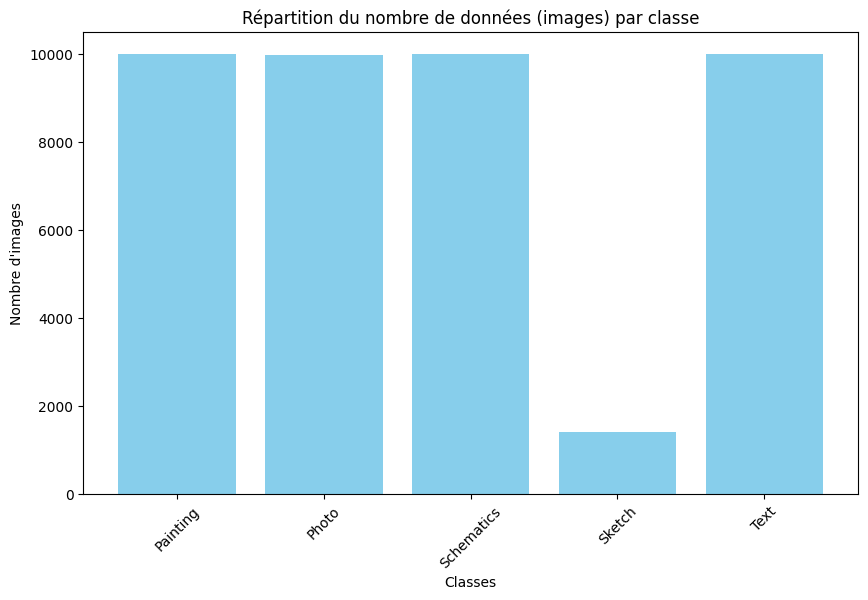

In [6]:
classes, image_counts = get_infos_datas(dataset_path) # Appel de la fonction pour récupérer les infos du dataset
image_in_Sketch = image_counts[3] # Nombre d'images dans la classe Sketch

## Afficher des images
Fonction pour afficher une image aléatoire par classe.

In [7]:
def display_random_images(dataset_path):
    """
    Affiche un nombre aléatoire d'images d'une classe donnée.
    
    :param dataset_path: Chemin vers le dataset
    :param num_images: Nombre d'images à afficher (par défaut 5)
    """
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        random_image = random.choice(images)
        img_path = os.path.join(class_path, random_image)
        img = PIL.Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

def display_random_images_with_predictions(dataset_path, model, class_to_index, image_size=(224, 224), num_images=5):
    """
    Affiche des images aléatoires du dataset avec la classe réelle et la prédiction du modèle.
    
    :param dataset_path: Chemin vers le dataset
    :param model: Le modèle entraîné
    :param class_to_index: Dictionnaire des classes vers index
    :param image_size: Taille cible de l'image pour le modèle
    :param num_images: Nombre d'images à afficher
    """
    # Inverser le dictionnaire pour index -> classe
    index_to_class = {v: k for k, v in class_to_index.items()}
    
    # Lister toutes les images du dataset avec leurs classes réelles
    all_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                all_images.append((os.path.join(class_path, image_name), class_name))
    
    # Choisir aléatoirement les images
    random_images = random.sample(all_images, num_images)

    # Affichage
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 5))

    for idx, (img_path, real_class) in enumerate(random_images):
        # Charger et prétraiter l'image
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prédiction
        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction[0])
        predicted_class = index_to_class[predicted_index]

        # Affichage
        axes[idx].imshow(Image.open(img_path))
        axes[idx].axis("off")
        axes[idx].set_title(f"Réel: {real_class}\nPrédit: {predicted_class}", fontsize=10)

    plt.tight_layout()
    plt.show()

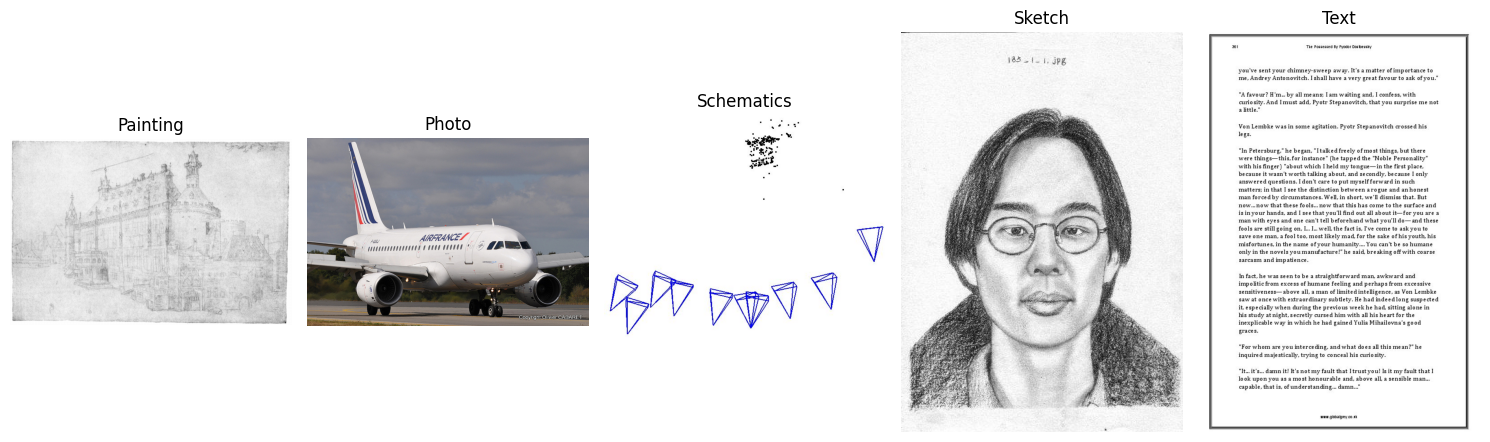

In [8]:
display_random_images(dataset_path)  # Affichage de 5 images aléatoires d'une classe donnée

## Nettoyage des données
La fonction suivante permet de parcourir le dataset et de supprimer les fichiers non images et les images corrompus.

In [9]:
# Suppresion des fichiers corrompus ou non images --------------------------------------------------------------------
def clean_images_dataset(dataset_path_arg):
    """
    Fonction pour nettoyer le dataset en supprimant les fichiers corrompus ou non images.
    """
    # Dictionnaire pour stocker le nombre d'images corrompues par classe
    corrupted_count_by_class = defaultdict(int)
    dataset_path = dataset_path_arg
    print("Début de la vérification des images ...")

    # Récupération de toutes les images pour calculer la progression
    all_files = []
    for dir_name in os.listdir(dataset_path): 
        dir_path = os.path.join(dataset_path, dir_name)
        for file_name in os.listdir(dir_path):
            all_files.append((dir_name, dir_path, file_name))

    total_files = len(all_files)
    checked_files = 0  # Pour la progression

    # Parcours des images avec affichage de la progression
    for dir_name, dir_path, file_name in all_files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with open(os.path.join(dir_path, file_name), 'rb') as file:
                    img_bytes = file.read()  # Lire les bytes de l'image
                    img = tf.image.decode_image(img_bytes)  # Essayer de décoder l'image
            except Exception as e:
                corrupted_count_by_class[dir_name] += 1
                print(f"\nImage corrompue : {file_name} dans {dir_name}. Exception: {e}")
                os.remove(os.path.join(dir_path, file_name))
                print(f"Image {file_name} supprimée.")
        else:
            corrupted_count_by_class[dir_name] += 1
            print(f"\nLe fichier {file_name} dans {dir_name} n'est pas une image.")
            os.remove(os.path.join(dir_path, file_name))
            print(f"Fichier {file_name} supprimé.")

        # Mise à jour de la progression
        checked_files += 1
        progress = (checked_files / total_files) * 100
        print(f"\rProgression : [{int(progress)}%] {checked_files}/{total_files} images vérifiées", end="")

    print("\nVérification des fichiers terminée.")

    # Affichage du nombre d'images corrompues par dossier
    for dir_name, count in corrupted_count_by_class.items():
        print(f"Dossier {dir_name} : {count} images corrompues")

    # Nombre total d'images corrompues
    total_corrupted = sum(corrupted_count_by_class.values())
    print(f"Nombre total d'images corrompues ou non image : {total_corrupted}")


In [10]:
clean_images_dataset(dataset_path)

Début de la vérification des images ...
Progression : [6%] 2661/41400 images vérifiées
Image corrompue : painting_02662.jpg dans Painting. Exception: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input size should match (header_size + row_size * abs_height) but they differ by 2 [Op:DecodeImage]
Image painting_02662.jpg supprimée.
Progression : [48%] 19993/41400 images vérifiées
Le fichier desktop.ini dans Schematics n'est pas une image.
Fichier desktop.ini supprimé.
Progression : [100%] 41400/41400 images vérifiées
Vérification des fichiers terminée.
Dossier Painting : 1 images corrompues
Dossier Schematics : 1 images corrompues
Nombre total d'images corrompues ou non image : 2


## Amélioration du dataset
Grâce à notre exploration des données précédentes, nous avons remarqué que l'une de nos classes (Sketch) possède un nombre de données bien inférieur aux autres classes.

Pour y remédier, plusieurs solutions sont envisageables :
- Augmenter la taille du dataset en ajoutant de nouvelles données provenant d'autres datasets.
- Générer de nouvelles données en appliquant des transformations sur les données existantes (rotations, zooms, flou, etc.).
- Ajuster la pondération des classes afin de compenser ce déséquilibre et améliorer l'apprentissage du modèle.

### Ajout de nouvelles données au dataset
Augmente la taille du dataset en ajoutant de nouvelles données provenant d'autres datasets.
- Dataset pour les sketch jpg : https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip (https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/)

- Dataset pour les sketch png : https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs

In [11]:
def download_kaggle_dataset(dataset_name, destination_folder):
    """
    Télécharge un dataset Kaggle en utilisant l'API Kaggle.
    Assurez-vous d'avoir configuré votre fichier kaggle.json dans ~/.kaggle/.
    """
    os.makedirs(destination_folder, exist_ok=True)
    try:
        os.system(f"kaggle datasets download -d {dataset_name} -p {destination_folder}")
    except ImportError:
        raise ImportError("Le module 'kaggle' n'est pas installé. Veuillez l'installer avec 'pip install kaggle'.")
    zip_path = os.path.join(destination_folder, f"{dataset_name.split('/')[-1]}.zip")
    print(zip_path)
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
    os.remove(zip_path)
    print(f"Dataset {dataset_name} téléchargé et extrait dans {destination_folder}.")

def download_http_dataset(url, destination_folder):
    """
    Télécharge un dataset depuis une URL HTTP.
    """
    os.makedirs(destination_folder, exist_ok=True)
    file_name = os.path.join(destination_folder, url.split('/')[-1])
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Fichier téléchargé : {file_name}")
        if file_name.endswith('.zip'):
            with ZipFile(file_name, 'r') as zip_ref:
                zip_ref.extractall(destination_folder)
            os.remove(file_name)
            print(f"Fichier extrait dans {destination_folder}.")
    else:
        print(f"Échec du téléchargement depuis {url}.")

def delete_duplicate_images(dataset_path):
    """
    Supprime les images dupliquées dans le dataset.
    """
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            seen_images = set()
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                if filename in seen_images:
                    print(f"Image dupliquée supprimée : {file_path}")
                    os.remove(file_path)
                else:
                    seen_images.add(filename)


def add_datas_to_dataset(dataset_path, dataset_faces_path, dataset_sketch_path):
    """
    Remplace les images du dossier Sketch dans dataset_path
    par celles venant de png/airplane et original_sketch.
    """

    # Chemin vers la classe cible dans le dataset principal
    target_class_path = os.path.join(dataset_path, "Sketch")
    
    # Définir les chemins source
    sketch_airplane_path = os.path.join(dataset_sketch_path, "png", "airplane")
    original_sketch_path = os.path.join(dataset_faces_path, "original_sketch")

    # Fusionner les deux dossiers source
    for src_path in [sketch_airplane_path, original_sketch_path]:
        if os.path.exists(src_path):
            for image_name in os.listdir(src_path):
                source_image_path = os.path.join(src_path, image_name)
                if os.path.isfile(source_image_path):
                    shutil.copy(source_image_path, target_class_path)

    # Supprimer les dossiers temporaires
    shutil.rmtree(dataset_faces_path, ignore_errors=True)
    shutil.rmtree(dataset_sketch_path, ignore_errors=True)
    print(f"Dossiers temporaires supprimés :\n- {sketch_airplane_path}\n- {original_sketch_path}")

    print(f"Images copiées depuis :\n- {sketch_airplane_path}\n- {original_sketch_path}\nvers : {target_class_path}")

In [12]:
# Télécharge les datasets depuis Kaggle et HTTP, les ajoute au dataset principal et supprime les images dupliquées
# Assurez-vous d'avoir configuré votre fichier kaggle.json dans ~/user/name/.kaggle/ pour utiliser l'API Kaggle

# Télécharger le dataset Kaggle
download_kaggle_dataset("arbazkhan971/cuhk-face-sketch-database-cufs", "./Dataset/CUHK_Face_Sketch_Database")

# Télécharger le dataset depuis une URL HTTP
download_http_dataset("https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip", "./Dataset/classifysketch")

# Merger les datasets
add_datas_to_dataset(dataset_path, "./Dataset/CUHK_Face_Sketch_Database", "./Dataset/classifysketch")

# Supprimer les images dupliquées
delete_duplicate_images(dataset_path)

./Dataset/CUHK_Face_Sketch_Database\cuhk-face-sketch-database-cufs.zip
Dataset arbazkhan971/cuhk-face-sketch-database-cufs téléchargé et extrait dans ./Dataset/CUHK_Face_Sketch_Database.
Fichier téléchargé : ./Dataset/classifysketch\sketches_png.zip
Fichier extrait dans ./Dataset/classifysketch.
Dossiers temporaires supprimés :
- ./Dataset/classifysketch\png\airplane
- ./Dataset/CUHK_Face_Sketch_Database\original_sketch
Images copiées depuis :
- ./Dataset/classifysketch\png\airplane
- ./Dataset/CUHK_Face_Sketch_Database\original_sketch
vers : ./Dataset/Dataset1\Sketch


Classes :  ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Nombre d'images par classe :  [9999, 9993, 10000, 2600, 10000]


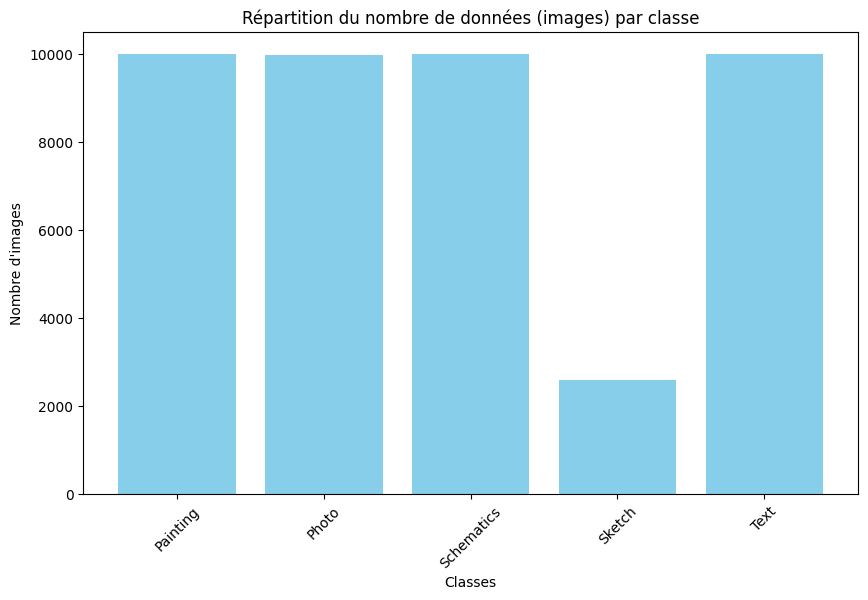

(['Painting', 'Photo', 'Schematics', 'Sketch', 'Text'],
 [9999, 9993, 10000, 2600, 10000])

In [13]:

# Afficher les classes et le nombre d'images par classe après ajout
get_infos_datas(dataset_path)
# print("La classe Sketch a été mise à jour avec les nouvelles images, un ajout de", image_counts[3] - image_in_Sketch  ,"images.")

### Datas augmentation
Génére de nouvelles données en appliquant des transformations sur les données existantes (rotations, zooms, translation, etc.).

In [14]:

def datas_augmentation(dataset_path, class_to_augment ,num_images_gen=2):
    """
    Fonction pour générer des images augmentées à partir d'un dataset existant pour toutes les classes.
    """
    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

 
    dir_path = os.path.join(dataset_path, class_to_augment)
    # print(f"Traitement du dossier : {dir_path}")
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        # print(f"Traitement de l'image : {img_path}")
        img = load_img(img_path)  # Charger l'image
        img = img_to_array(img)   # Convertir en tableau numpy
        img = np.expand_dims(img, axis=0)

        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=dir_path, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= num_images_gen:  # Générer environ X nouvelles images par image existante (pour arriver à 10k)
                break


In [15]:
# datas_augmentation(dataset_path, "Sketch", 2)
# get_infos_datas(dataset_path)

### Ponderation

Calcule les poids des classes en fonction du nombre d'images par classe. 

In [16]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(dataset_path):
    """
    Calcule les poids des classes en fonction du nombre d'images par dossier de classe.

    Args:
        dataset_path (str): Chemin vers le dossier contenant les sous-dossiers de classes.

    Returns:
        dict: Dictionnaire {nom_de_classe: poids}.
    """
    y_labels = []

    # Parcours de chaque dossier de classe
    class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        y_labels.extend([class_name] * len(image_files))

    y_labels = np.array(y_labels)

    # Création d'un mapping classe -> index
    class_to_index = {class_name: idx for idx, class_name in enumerate(np.unique(y_labels))}

    # Convertir les labels texte en index
    y_labels_indices = np.array([class_to_index[label] for label in y_labels])

    # Calcule les poids
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels_indices), y=y_labels_indices)

    # Crée un dictionnaire {index_classe: poids}
    class_weights_dict = {idx: weight for idx, weight in zip(np.unique(y_labels_indices), class_weights)}

    return class_weights_dict, class_to_index

In [17]:
class_weight_dict, class_to_index = compute_class_weights(dataset_path)
# Affichage des poids des classes
for class_name, weight in class_weight_dict.items():
    print(f"Classe : {class_name}, Poids : {weight}")

Classe : 0, Poids : 0.8519251925192519
Classe : 1, Poids : 0.8524367056939858
Classe : 2, Poids : 0.85184
Classe : 3, Poids : 3.276307692307692
Classe : 4, Poids : 0.85184


## Import des données
Nous déclarons également nos variables pour le futur entraînement de notre modèle.

Nous importons nos données grâce à TensorFlow afin de les manipuler par la suite avec cette librairie.

In [18]:
image_size = (180, 180)  # Taille des images
batch_size = 32  # Taille du lot
epochs = 10  # Nombre d'époques

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Définition du callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Surveille la validation loss
    patience=3,            # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True # Recharge les meilleurs poids après l'arrêt
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip('horizontal', input_shape=(image_size[0], image_size[1], 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
  ]
)

c:\Users\mallo\OneDrive\Bureau\CESI 2022 - 2025\Annee 5\Semestre 10\Option data science\Project\Data-science-project-A5\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# chargement des images
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

dataset_path = "./Dataset/Dataset1"
# Le train_set augmented
train_set_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  "./Dataset/Dataset1_DataAugmented",
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

# Le test_set augmented
test_set_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  "./Dataset/Dataset1_DataAugmented",
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

Found 42592 files belonging to 5 classes.
Using 34074 files for training.
Found 42592 files belonging to 5 classes.
Using 8518 files for validation.
Found 46655 files belonging to 5 classes.
Using 37324 files for training.
Found 46655 files belonging to 5 classes.
Using 9331 files for validation.


# Pipeline Classification

Fonction pour afficher les metrics de nos modèles après entraînement.

In [21]:
# FONCTION POUR AFFICHER LES METRICS
def plot_metrics(history):
    # Accéder à l'historique des métriques
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    precision = history.history.get('precision')  
    val_precision = history.history.get('val_precision')

    recall = history.history.get('recall')  
    val_recall = history.history.get('val_recall')

    # Nombre d'époques effectivement utilisées (en tenant compte du EarlyStopping)
    epochs_used = len(acc) 

    epochs_range = range(epochs_used)
    plt.figure(figsize=(16, 8))

    # Graphique 1 - Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Graphique 2 - Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Graphique 3 - Precision (si disponible)
    if precision and val_precision:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, precision, label='Training Precision')
        plt.plot(epochs_range, val_precision, label='Validation Precision')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Precision')

    # Graphique 4 - Recall (si disponible)
    if recall and val_recall:
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, recall, label='Training Recall')
        plt.plot(epochs_range, val_recall, label='Validation Recall')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Recall')

    plt.tight_layout()
    plt.show()

In [22]:
def save_model(model, model_name):
    """
    Enregistre le modèle dans un fichier HDF5.
    """
    model.save(model_name +".h5")
    print(f"Modèle enregistré sous {model_name}.h5")

def save_weights(model, model_name):
    """
    Enregistre les poids du modèle dans un fichier HDF5.
    """
    model.save_weights(model_name +".h5")
    print(f"Poids du modèle enregistrés sous {model_name}.h5")

def load_model(model_name):
    """
    Charge le modèle depuis un fichier HDF5.
    """
    model = keras.models.load_model(model_name +".h5")
    print(f"Modèle chargé depuis {model_name}.h5")
    return model

def load_weights(model, model_name):
    """
    Charge les poids du modèle depuis un fichier HDF5.
    """
    model.load_weights(model_name +".h5")
    print(f"Poids du modèle chargés depuis {model_name}.h5")

In [23]:
# prédire une image
def predict_image(model, image_path, class_to_index):
    """
    Prédit la classe d'une image donnée.
    """
    # Charger et prétraiter l'image
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Normaliser l'image
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch

    # Faire la prédiction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    
    # Convertir l'index de classe en nom de classe
    index_to_class = {v: k for k, v in class_to_index.items()}
    predicted_class_name = index_to_class[predicted_class_index]
    
    return predicted_class_name

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def display_images_with_predictions(model, dataset_path, true_classes):
    """
    Affiche les images d'un dossier avec la classe réelle et la prédiction du modèle.

    Args:
        model (keras.Model): Le modèle de prédiction.
        dataset_path (str): Le chemin vers le dossier contenant les images.
        true_classes (list): Liste des classes réelles (ordre des images dans le dossier).
    """

    class_index = {"Painting": 1, "Photo": 2, "Schematics": 3, "Sketch": 4, "Text": 5} 
    # Récupérer la liste des fichiers d'images dans le dossier
    image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
    
    # Configurer l'affichage des images dans une grille
    n = len(image_files)
    ncols = 5  # Nombre de colonnes dans la grille
    nrows = (n + ncols - 1) // ncols  # Nombre de lignes, arrondi au nombre entier supérieur
    plt.figure(figsize=(ncols * 3, nrows * 3))  # Taille de la figure (ajustée à la grille)
    
    for i, image_name in enumerate(image_files):
        # Charger l'image et la prétraiter pour le modèle
        img_path = os.path.join(dataset_path, image_name)
        img = image.load_img(img_path, target_size=(180, 180))  # Taille à adapter selon ton modèle
        img_array = image.img_to_array(img)  # Normalisation de l'image
        img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour batch
        

        # Faire la prédiction
        prediction = model.predict(img_array)
        scores = tf.nn.softmax(prediction[0])
        class_names = train_set.class_names
        predicted_label = class_names[np.argmax(scores)]
        confidence = 100 * np.max(scores)

        predicted_class = np.argmax(prediction, axis=1)[0]  # Classe prédite
        # predicted_class = list(class_index.keys())[list(class_index.values()).index(predicted_class)]
        true_class = true_classes[i]  # Classe réelle à partir du tableau passé en paramètre


        # Affichage de l'image avec la classe réelle et la prédiction
        plt.subplot(nrows, ncols, i + 1)  # Positionner l'image dans la grille
        plt.imshow(img)
        plt.title(f"Classe réel: {true_class}\nClasse Predite: {predicted_label}\nConfiance: {confidence:.2f}%")
        plt.axis('off')  # Masquer les axes

    plt.tight_layout()
    plt.show()


In [103]:
import matplotlib.pyplot as plt

def compare_models(histories, labels=None):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs_range = range(len(acc))
        label = labels[i] if labels else f'Model {i+1}'

        # plt.plot(epochs_range, acc, label=f'{label} - Train')
        plt.plot(epochs_range, val_acc, linestyle='--', label=f'{label} - Val')

    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(loss))
        label = labels[i] if labels else f'Model {i+1}'

        # plt.plot(epochs_range, loss, label=f'{label} - Train')
        plt.plot(epochs_range, val_loss, linestyle='--', label=f'{label} - Val')

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Modèle de classification n°1 : CNN classique

- Dataset : par défault (Dataset1)
- Optimizer : Adam
- loss : SparseCategoricalCrossentropy de tensorflow

In [26]:
# Modelisation du modèle
model_Categorical_basic = Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax'),
    ])

model_Categorical_basic.compile(optimizer='adam',
                        loss='SparseCategoricalCrossentropy',
                        metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

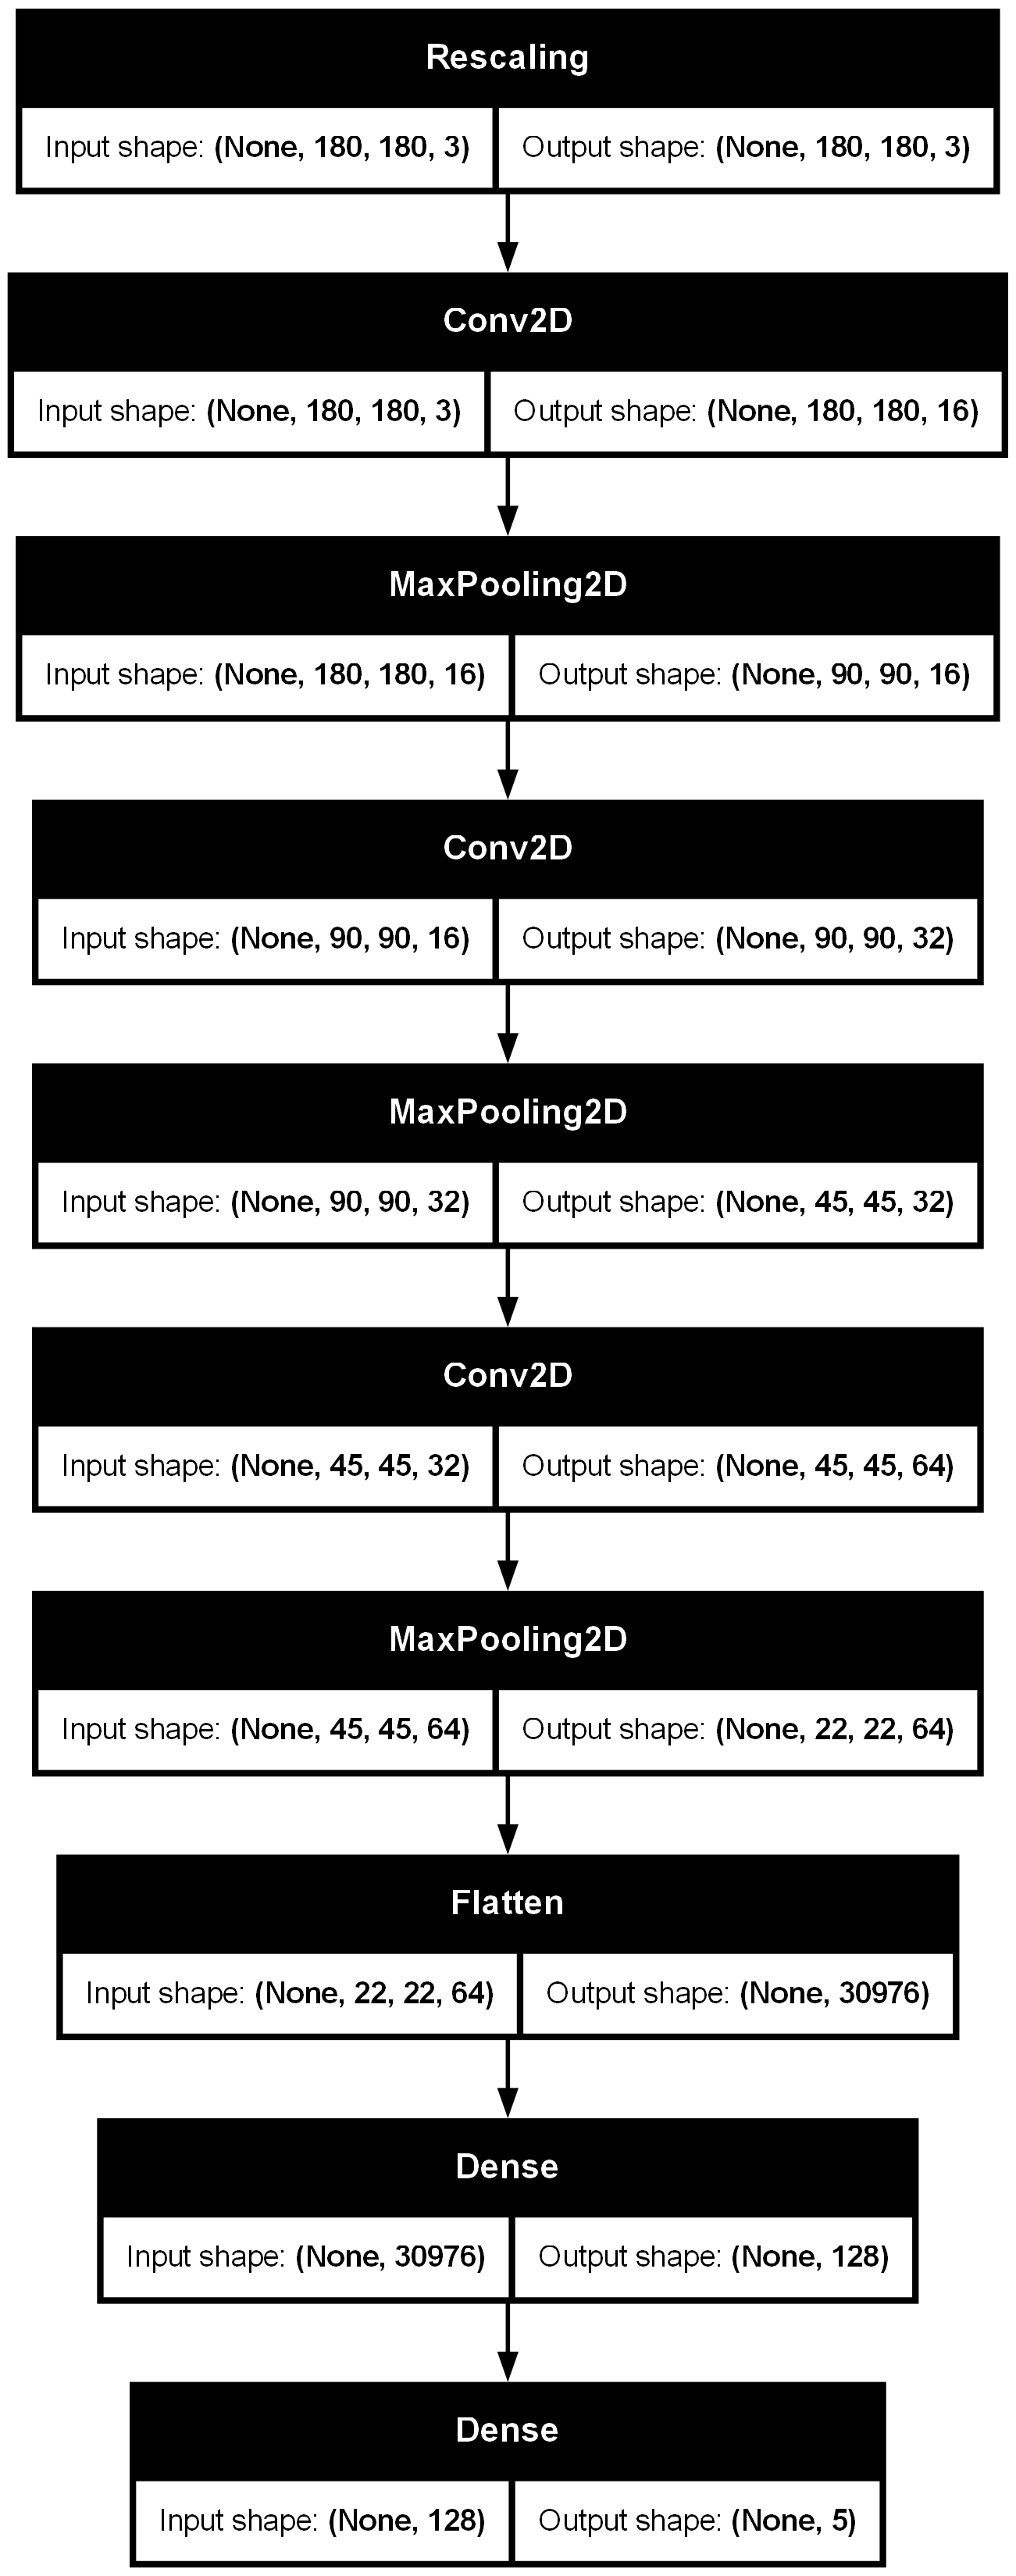

In [27]:
# visualisation de l'architecture du modèle
from keras.utils import plot_model
model_Categorical_basic.summary()
plot_model(model_Categorical_basic, to_file='model_Categorical_basic.png', show_shapes=True)

In [28]:
# Entraînement du modèle
history1 = model_Categorical_basic.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 104s 96ms/step - accuracy: 0.6918 - loss: 0.7715 - val_accuracy: 0.8490 - val_loss: 0.3623
Epoch 2/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 102s 96ms/step - accuracy: 0.8709 - loss: 0.3268 - val_accuracy: 0.8705 - val_loss: 0.3377
Epoch 3/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 101s 95ms/step - accuracy: 0.9079 - loss: 0.2336 - val_accuracy: 0.9026 - val_loss: 0.2759
Epoch 4/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 101s 95ms/step - accuracy: 0.9394 - loss: 0.1636 - val_accuracy: 0.9024 - val_loss: 0.3042
Epoch 5/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 103s 97ms/step - accuracy: 0.9590 - loss: 0.1102 - val_accuracy: 0.8974 - val_loss: 0.3693
Epoch 6/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 104s 98ms/step - accuracy: 0.9702 - loss: 0.0811 - val_accuracy: 0.8846 - val_loss: 0.4872
Epoch 7/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 105s 98ms/step - accuracy: 0.9782 - loss: 0.0599 - val_accuracy: 0.9012 - val_loss: 0.4142
Epoch 8/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 105s 98ms/step - accuracy: 

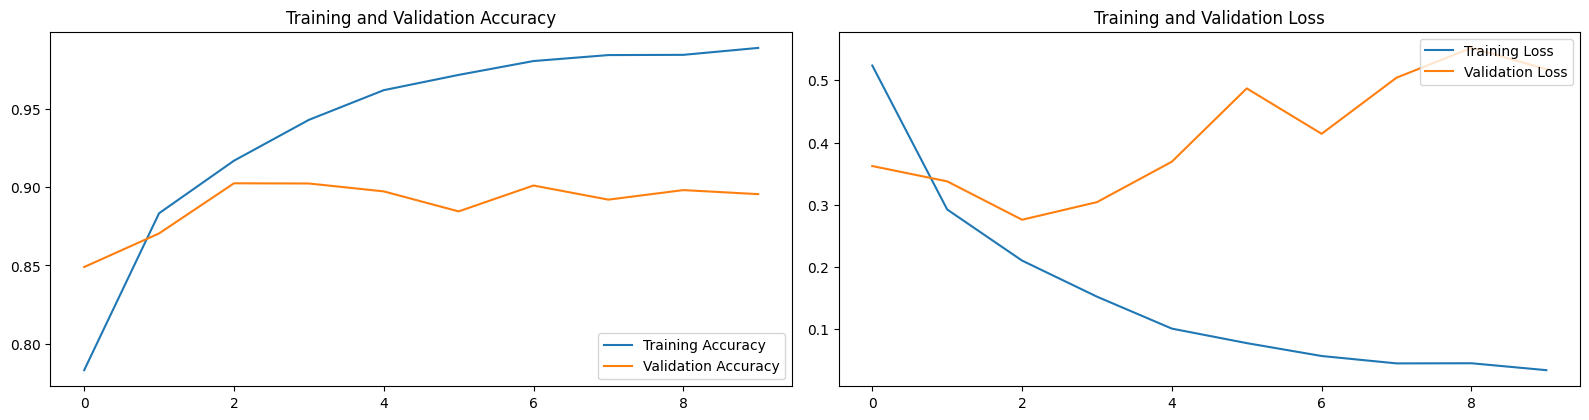

Modèle enregistré sous model_Categorical_basic.h5


In [29]:
plot_metrics(history1)
save_model(model_Categorical_basic, "model_Categorical_basic")

Modèle de classification n°2 : CNN classique avec dataset augmenté.

- Dataset : Dataset1_DataAugmented
- Optimizer : Adam
- loss : SparseCategoricalCrossentropy de tensorflow

In [30]:
# Modelisation du modèle
model_Categorical_basic2 = Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax'),
    ])

model_Categorical_basic2.compile(optimizer='adam',
                        loss='SparseCategoricalCrossentropy',
                        metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

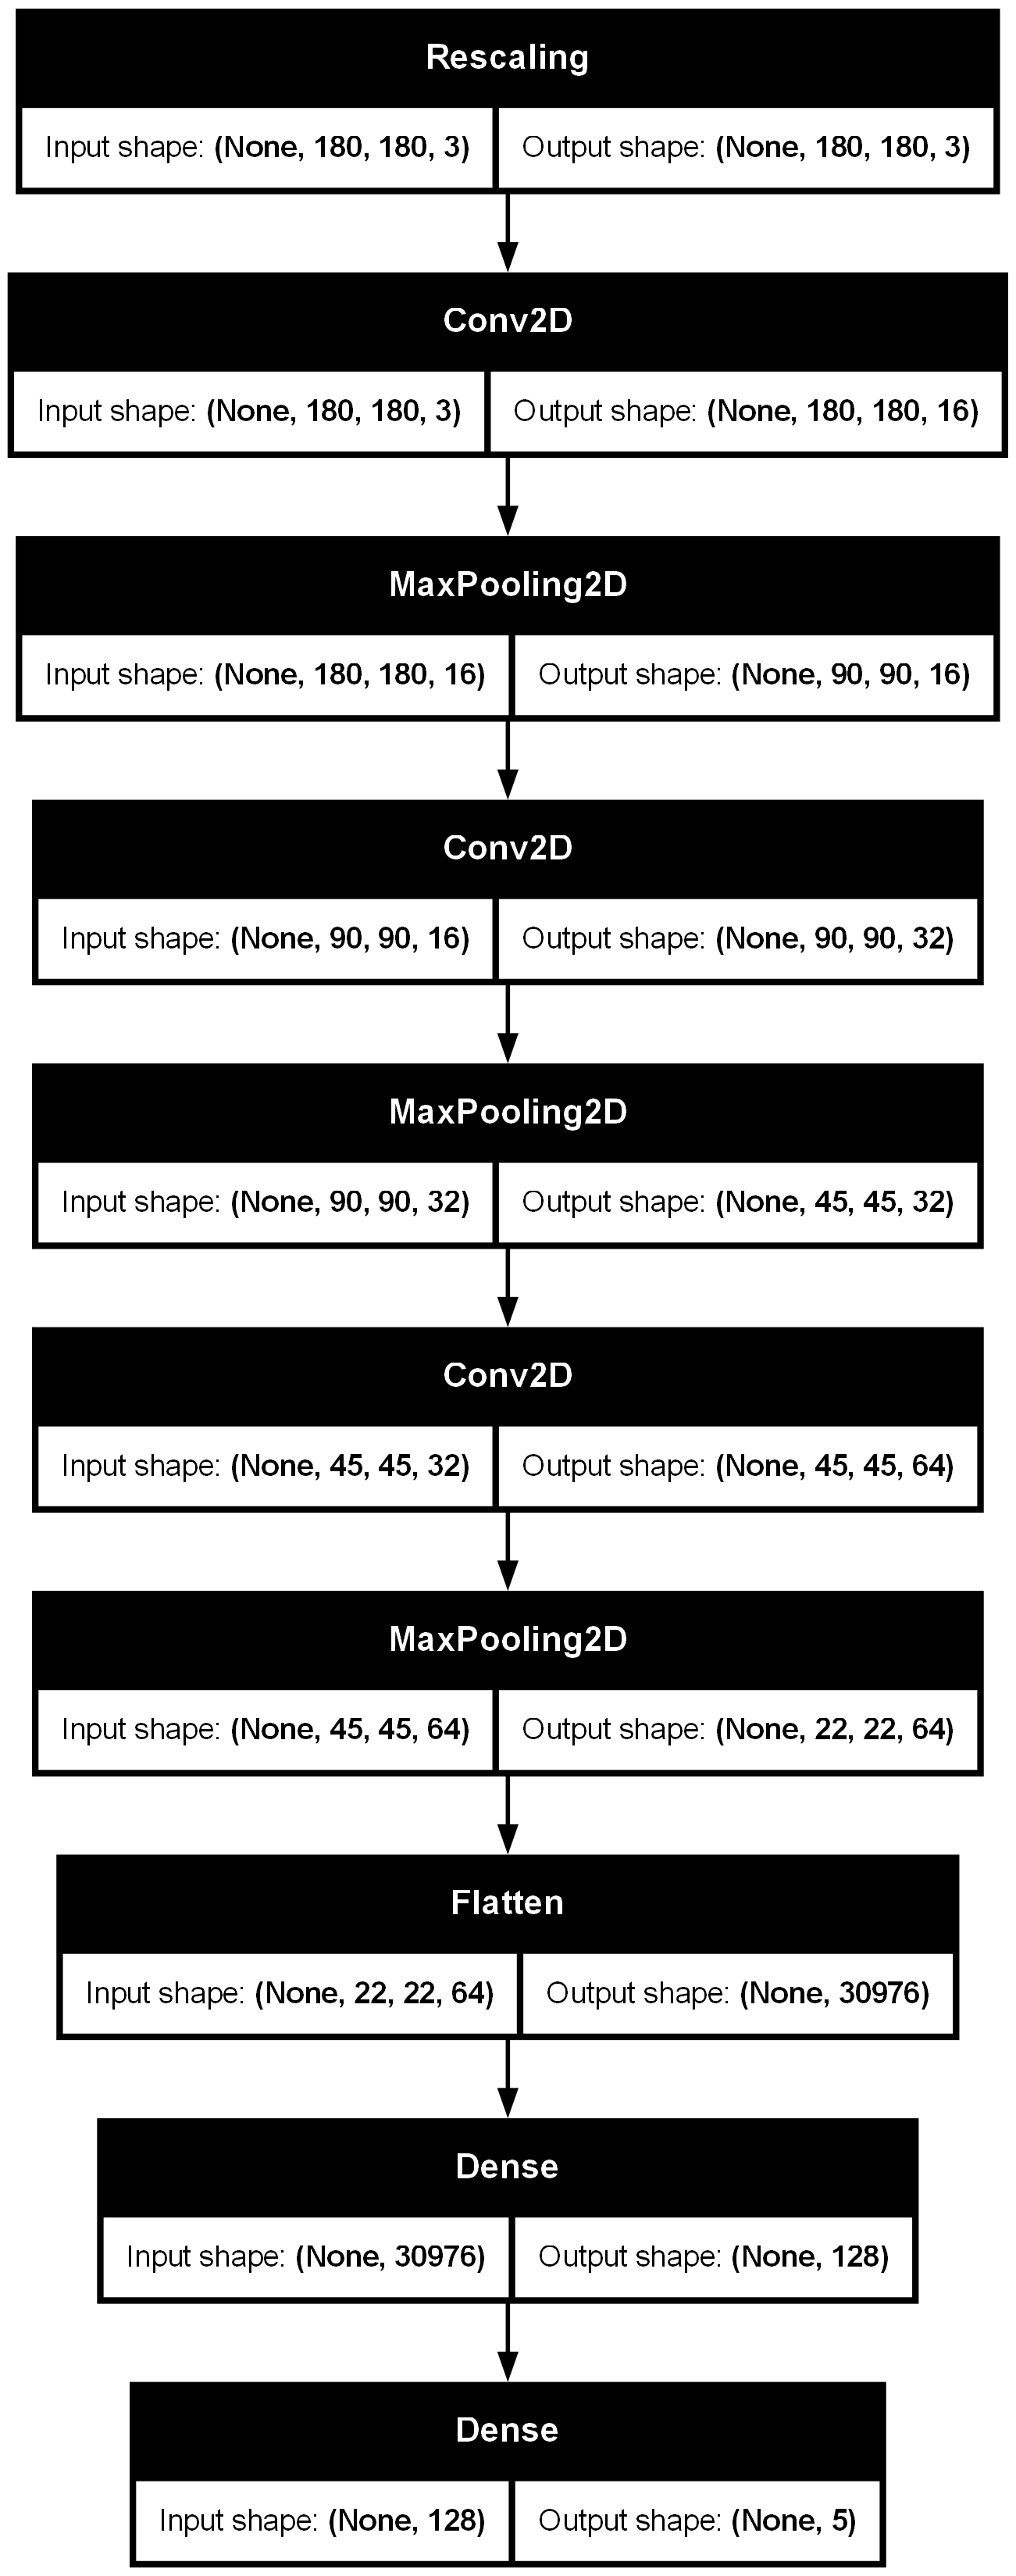

In [31]:
# visualisation de l'architecture du modèle
from keras.utils import plot_model
model_Categorical_basic2.summary()
plot_model(model_Categorical_basic2, to_file='model_Categorical_basic2.png', show_shapes=True)

In [32]:
# Entraînement du modèle
history2 = model_Categorical_basic2.fit(
    train_set_augmented,
    validation_data=test_set_augmented,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 96ms/step - accuracy: 0.7208 - loss: 0.6808 - val_accuracy: 0.8628 - val_loss: 0.3538
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 110s 94ms/step - accuracy: 0.8893 - loss: 0.2839 - val_accuracy: 0.9012 - val_loss: 0.2575
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 110s 95ms/step - accuracy: 0.9222 - loss: 0.1979 - val_accuracy: 0.9023 - val_loss: 0.2767
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 110s 94ms/step - accuracy: 0.9461 - loss: 0.1406 - val_accuracy: 0.9079 - val_loss: 0.2805
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy: 0.9591 - loss: 0.1068 - val_accuracy: 0.9118 - val_loss: 0.3195
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy: 0.9755 - loss: 0.0673 - val_accuracy: 0.9042 - val_loss: 0.3672
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 114s 97ms/step - accuracy: 0.9792 - loss: 0.0609 - val_accuracy: 0.9112 - val_loss: 0.3908
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy: 

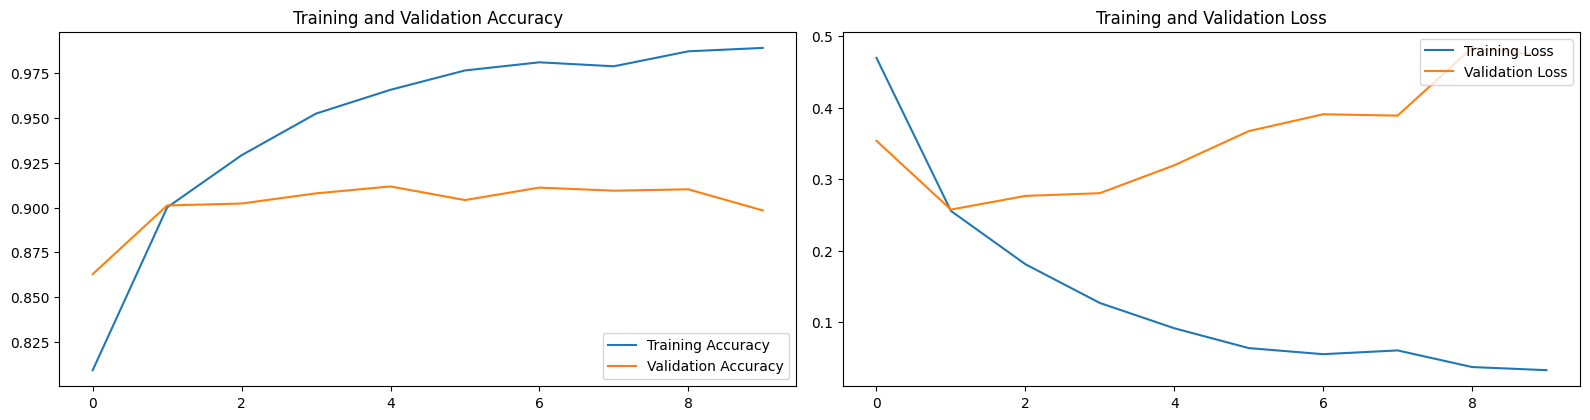

Modèle enregistré sous model_Categorical_basic2.h5


In [33]:
plot_metrics(history2)
save_model(model_Categorical_basic2, "model_Categorical_basic2")

Modele de classification n°3 : CNN modifié
- Dataset : par défaut (Dataset1)
- Optimizer : Adam
- loss : SparseCategoricalCrossentropy de tensorflow

Modifications :
- Ajout de dropout sur la couche de flatten.
- Ajout d'un earlyStopping dès lors que le modèle n'apprend plus au bout de 5 epochs.
- Ajout de la pondération des classes.

In [34]:
# Modelisation du modèle
model_Categorical_modified = Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),  # Ajout de Dropout pour réduire le surapprentissage
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax'),
    ])

model_Categorical_modified.compile(optimizer=Adam(learning_rate=0.001),
                        loss='SparseCategoricalCrossentropy',
                        metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

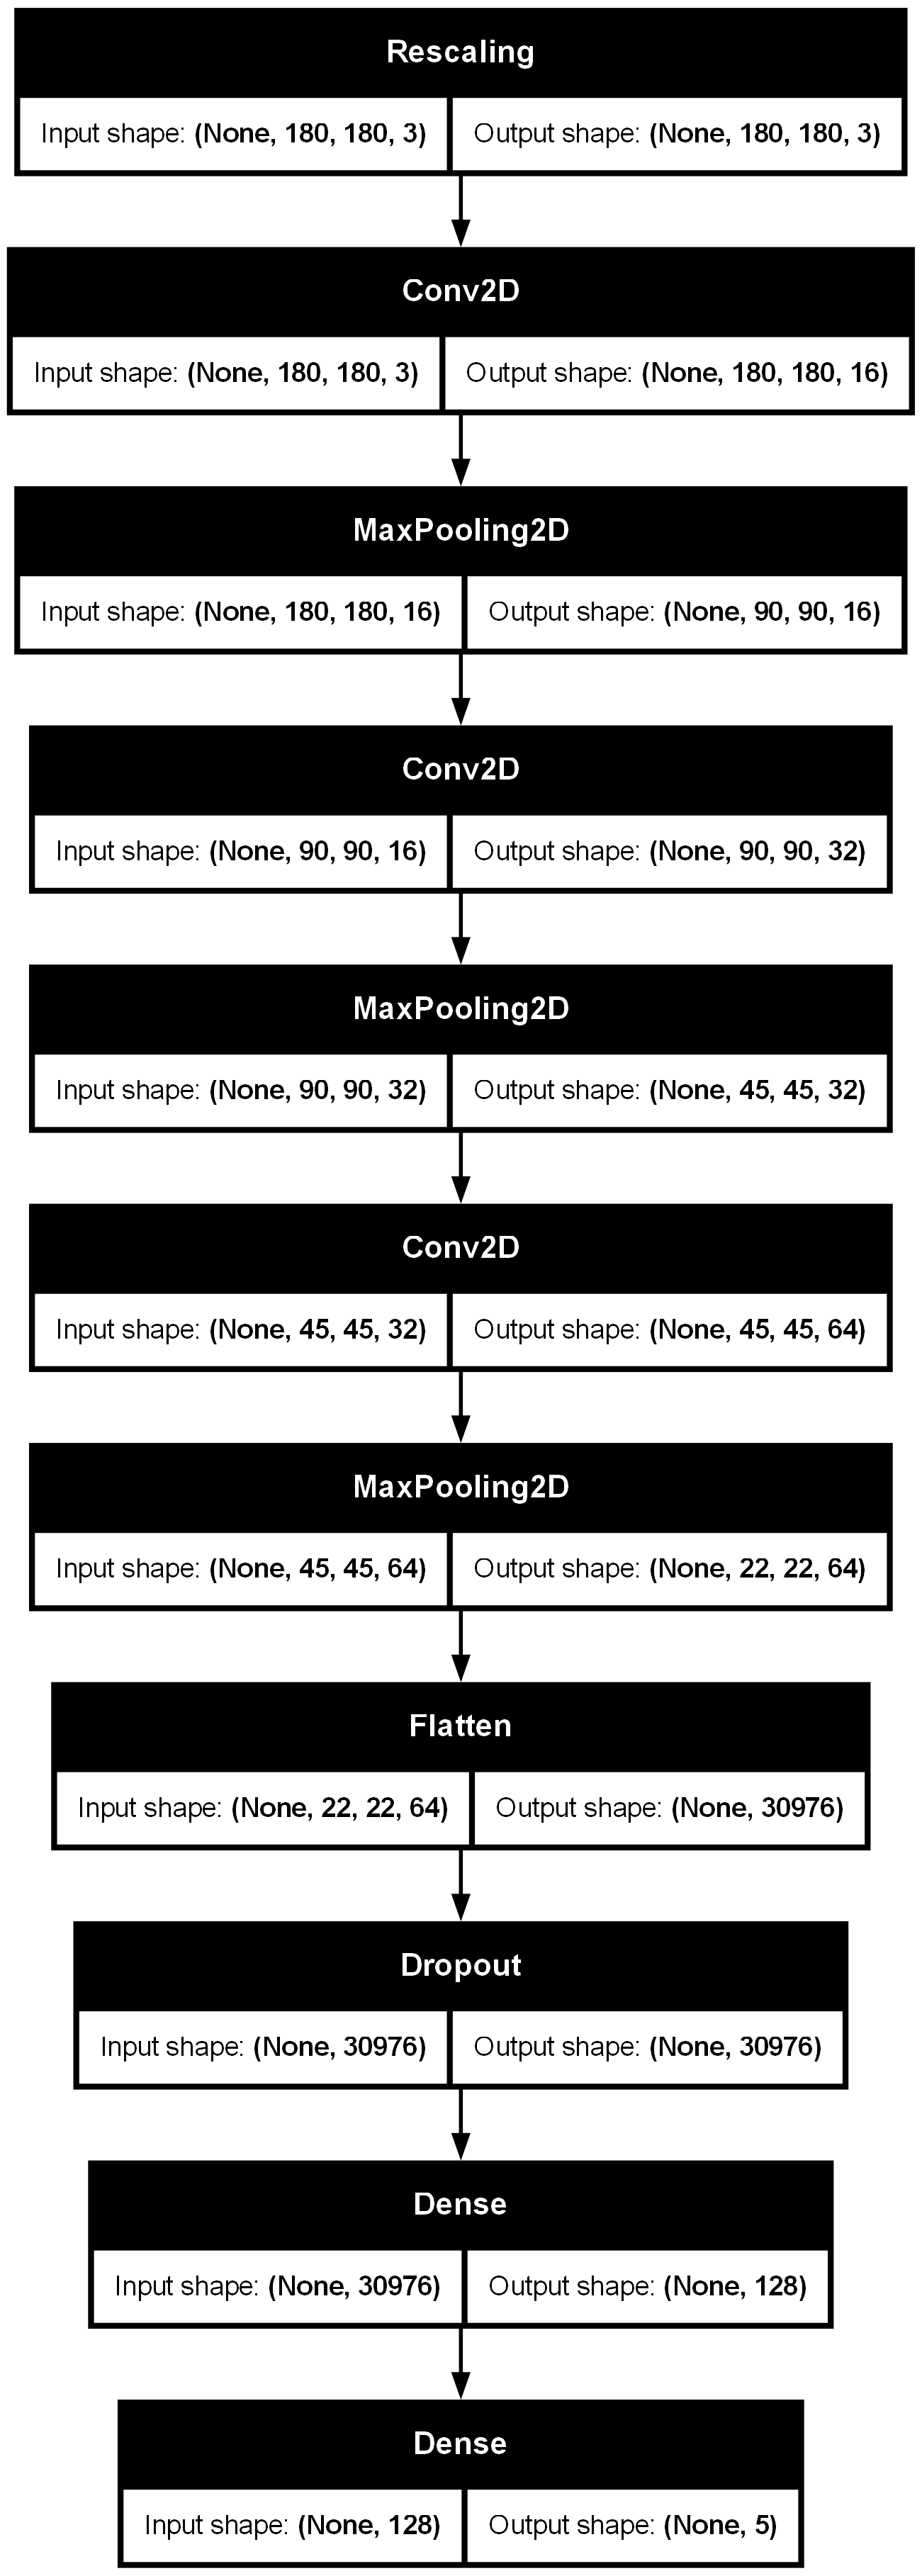

In [35]:
# visualisation de l'architecture du modèle
from keras.utils import plot_model
model_Categorical_modified.summary()
plot_model(model_Categorical_modified, to_file='model_Categorical_modified.png', show_shapes=True)

In [36]:
# Entraînement du modèle
history3 = model_Categorical_modified.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,  # Ajout des poids de classe
)

Epoch 1/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 106s 99ms/step - accuracy: 0.7135 - loss: 0.6486 - val_accuracy: 0.8092 - val_loss: 0.4295
Epoch 2/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.8664 - loss: 0.2856 - val_accuracy: 0.8869 - val_loss: 0.2901
Epoch 3/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 108s 102ms/step - accuracy: 0.8980 - loss: 0.2194 - val_accuracy: 0.9036 - val_loss: 0.2622
Epoch 4/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 115s 108ms/step - accuracy: 0.9245 - loss: 0.1678 - val_accuracy: 0.9009 - val_loss: 0.2866
Epoch 5/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 110s 103ms/step - accuracy: 0.9381 - loss: 0.1401 - val_accuracy: 0.8633 - val_loss: 0.4580
Epoch 6/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 109s 102ms/step - accuracy: 0.9471 - loss: 0.1235 - val_accuracy: 0.9044 - val_loss: 0.3112


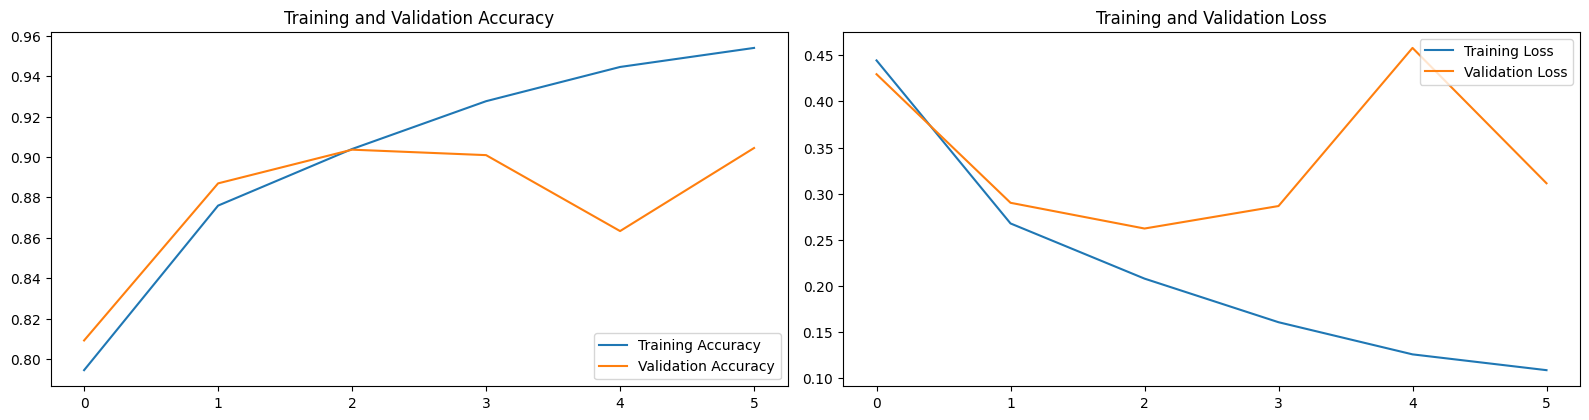

Modèle enregistré sous model_Categorical_modified.h5


In [37]:
# Afficher les metrics
plot_metrics(history3)
save_model(model_Categorical_modified, "model_Categorical_modified")

Modele de classification n°4 : CNN modifié
- Dataset : par défaut (Dataset1)
- Optimizer : Adam
- loss : SparseCategoricalCrossentropy de tensorflow

Modifications :

- Ajout de dropout sur la couche de flatten.
- Ajout d'un earlyStopping dès lors que le modèle n'apprend plus au bout de 5 epochs.
- Ajout de la pondération des classes.
- Suppression de la couche de rescaling


In [38]:
# Modelisation du modèle
model_Categorical_modified2 = Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu',input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),  # Ajout de Dropout pour réduire le surapprentissage
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax'),
    ])

model_Categorical_modified2.compile(optimizer=Adam(learning_rate=0.001),
                        loss='SparseCategoricalCrossentropy',
                        metrics=['accuracy'])

c:\Users\mallo\OneDrive\Bureau\CESI 2022 - 2025\Annee 5\Semestre 10\Option data science\Project\Data-science-project-A5\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

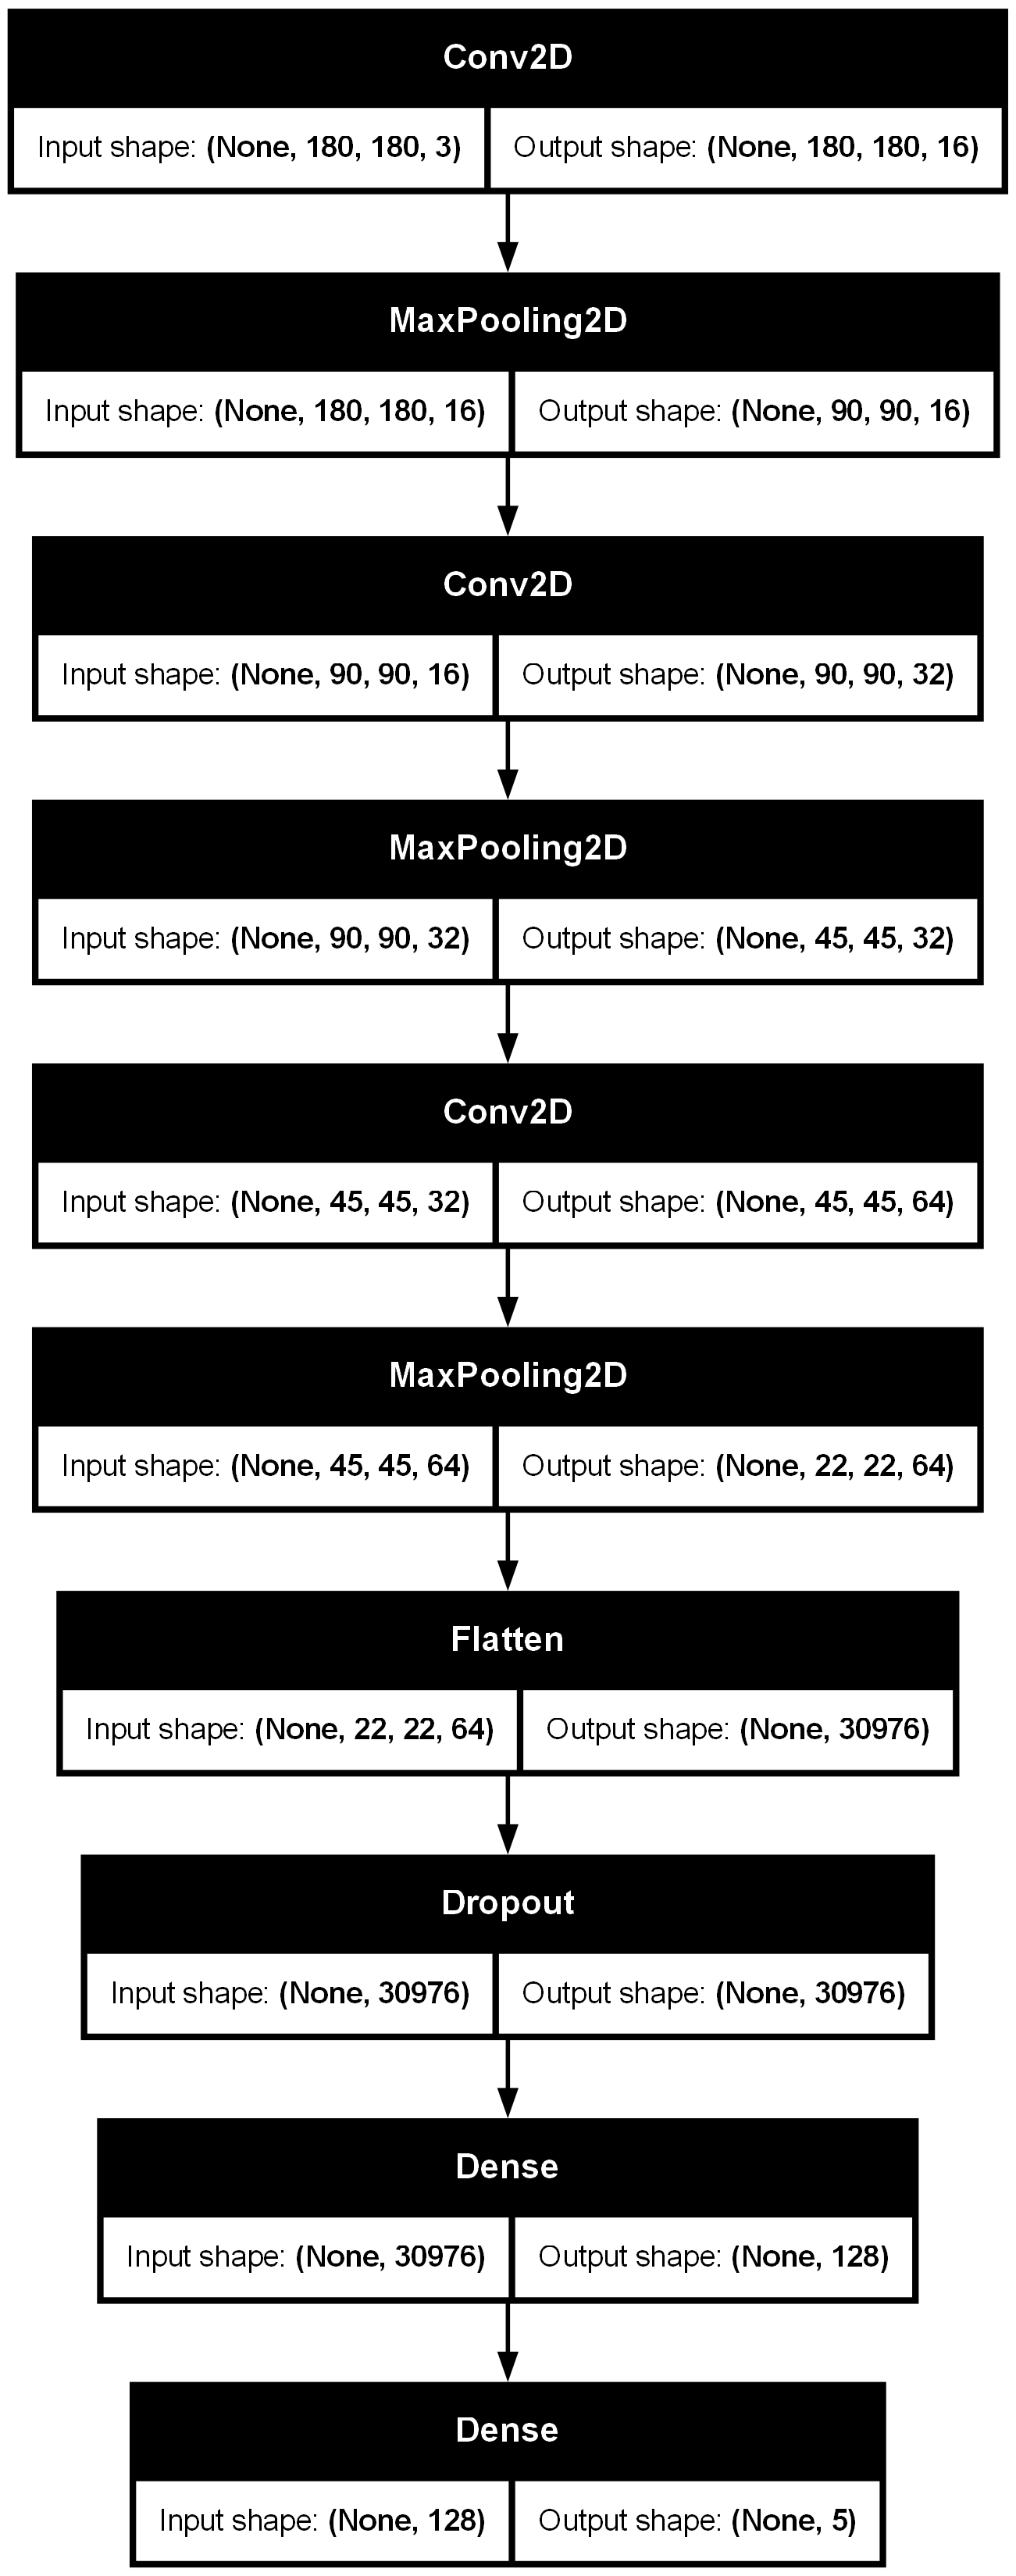

In [39]:
# visualisation de l'architecture du modèle
from keras.utils import plot_model
model_Categorical_modified2.summary()
plot_model(model_Categorical_modified2, to_file='model_Categorical_modified2.png', show_shapes=True)

In [40]:
# Entraînement du modèle
history4 = model_Categorical_modified2.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,  # Ajout des poids de classe
)

Epoch 1/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 105s 98ms/step - accuracy: 0.5901 - loss: 13.7350 - val_accuracy: 0.7452 - val_loss: 0.5878
Epoch 2/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.7322 - loss: 0.6076 - val_accuracy: 0.7079 - val_loss: 0.6887
Epoch 3/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 103s 97ms/step - accuracy: 0.7142 - loss: 0.6314 - val_accuracy: 0.7744 - val_loss: 0.5546
Epoch 4/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 103s 97ms/step - accuracy: 0.7565 - loss: 0.5321 - val_accuracy: 0.7800 - val_loss: 0.5177
Epoch 5/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 103s 97ms/step - accuracy: 0.8126 - loss: 0.4098 - val_accuracy: 0.8231 - val_loss: 0.4670
Epoch 6/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 103s 97ms/step - accuracy: 0.8520 - loss: 0.3195 - val_accuracy: 0.8373 - val_loss: 0.4509
Epoch 7/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 107s 101ms/step - accuracy: 0.8700 - loss: 0.2905 - val_accuracy: 0.8427 - val_loss: 0.4665
Epoch 8/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 107s 101ms/step - accurac

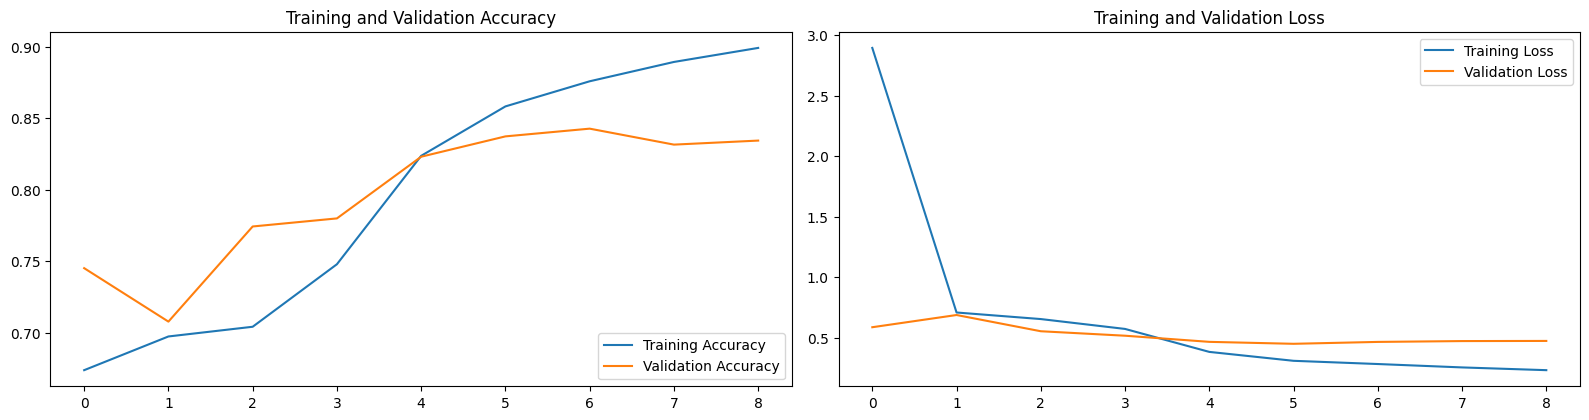

Modèle enregistré sous model_Categorical_modified2.h5


In [41]:
# Afficher les metrics
plot_metrics(history4)
save_model(model_Categorical_modified2, "model_Categorical_modified2")

Modele de classification n°5 : CNN modifié
- Dataset : avec data augmentation (Dataset1)
- Optimizer : Adam
- loss : SparseCategoricalCrossentropy de tensorflow

Modifications :
- Ajout de dropout sur la couche de flatten.
- Ajout d'un earlyStopping dès lors que le modèle n'apprend plus au bout de 5 epochs.
- Ajout de la pondération des classes.
- Suppression de la couche de rescaling
- Ajout de la couche de data augmentation
- Modification des couches de convolutions. (inversion des filtres 16 et 64)

In [42]:
# Modelisation du modèle
model_Categorical_modified3 = Sequential([
    data_augmentation,
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),  # Ajout de Dropout pour réduire le surapprentissage
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax'),
    ])

model_Categorical_modified3.compile(optimizer=Adam(learning_rate=0.001),
                        loss='SparseCategoricalCrossentropy',
                        metrics=['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,885 (3.88 MB)

 Trainable params: 1,016,885 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

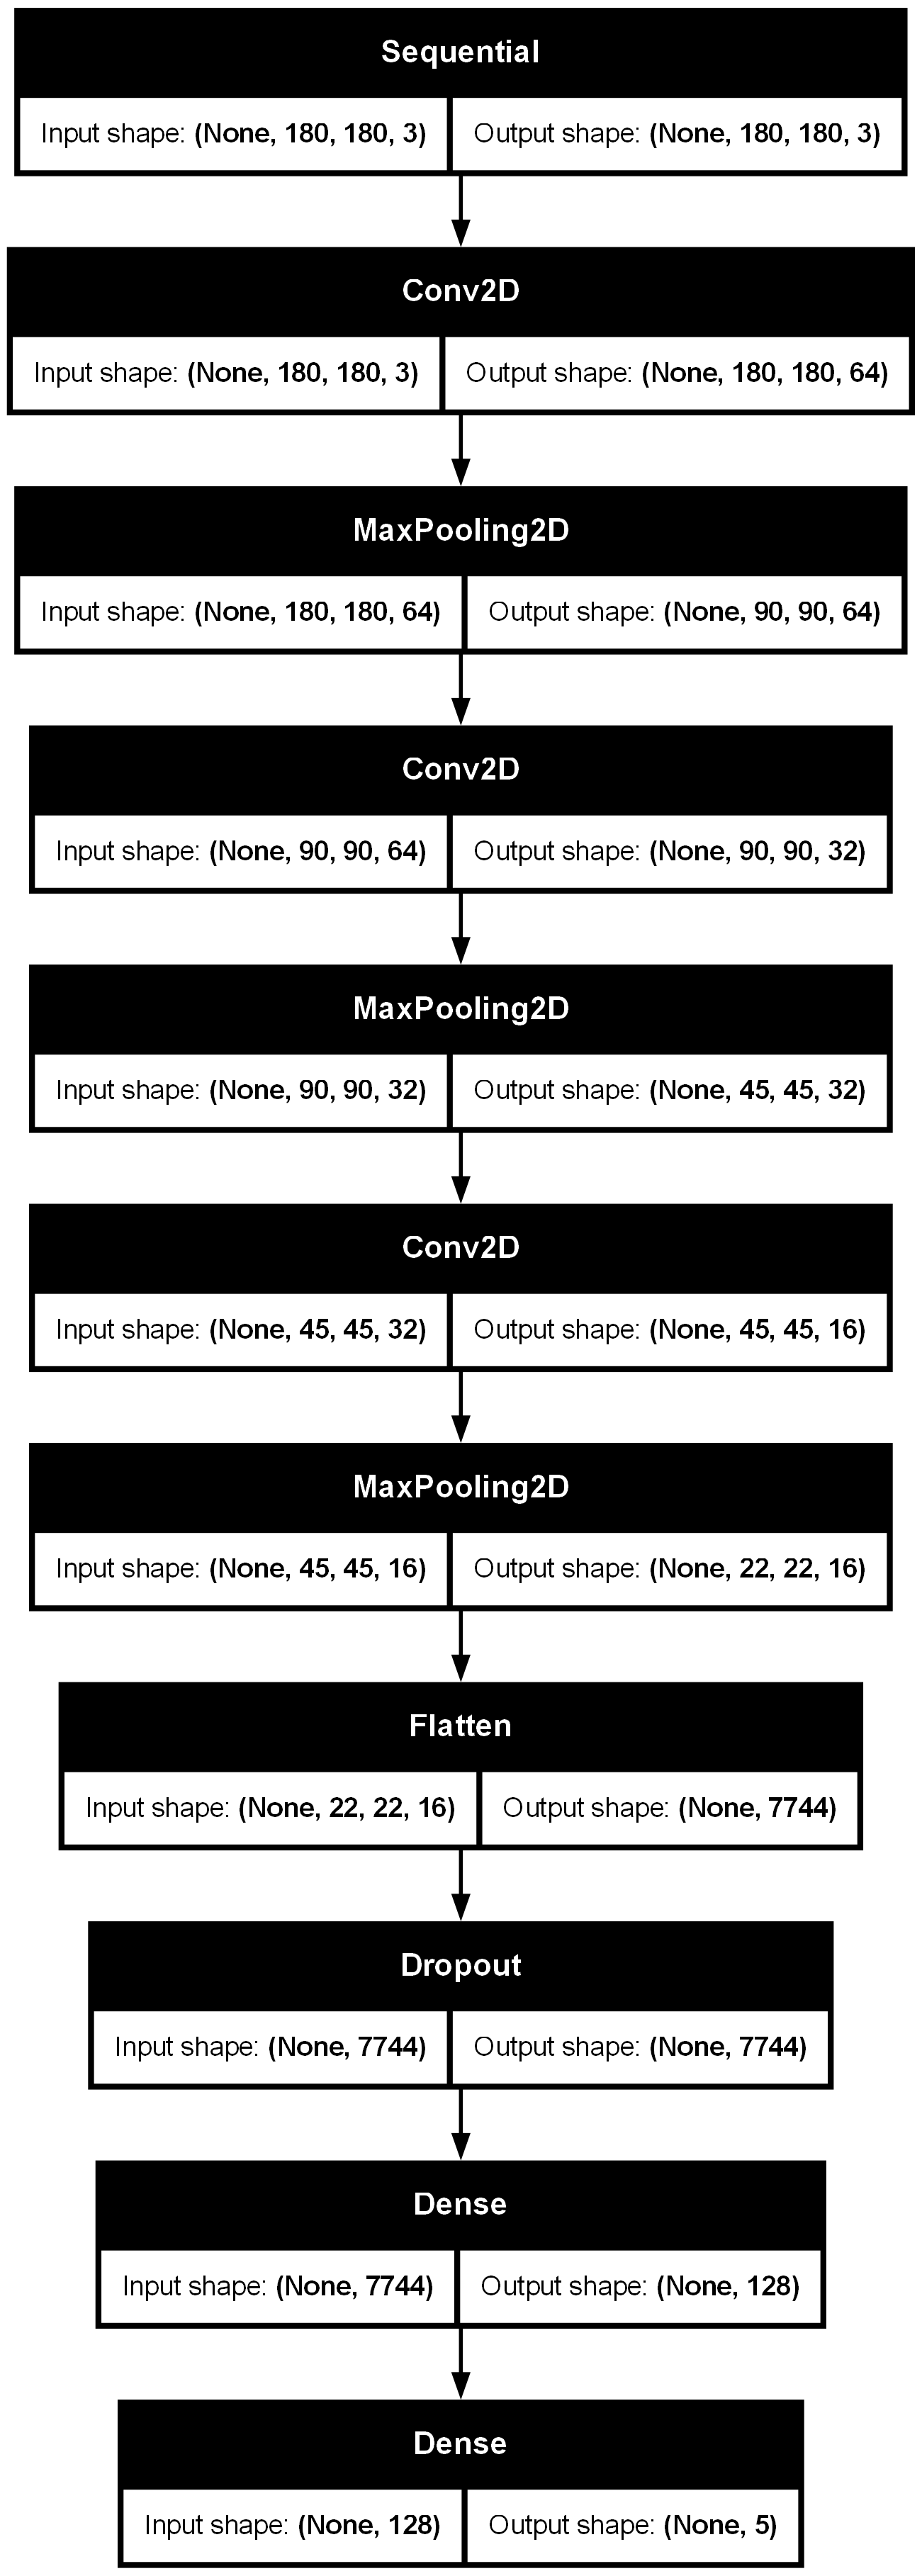

In [43]:
# visualisation de l'architecture du modèle
from keras.utils import plot_model
model_Categorical_modified3.summary()
plot_model(model_Categorical_modified3, to_file='model_Categorical_modified3.png', show_shapes=True)

In [44]:
# Entraînement du modèle
history5 = model_Categorical_modified3.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,  # Ajout des poids de classe
)

Epoch 1/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 245s 228ms/step - accuracy: 0.5006 - loss: 3.1895 - val_accuracy: 0.3556 - val_loss: 1.2859
Epoch 2/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 242s 227ms/step - accuracy: 0.6035 - loss: 0.9116 - val_accuracy: 0.6097 - val_loss: 0.9540
Epoch 3/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 242s 227ms/step - accuracy: 0.6892 - loss: 0.7537 - val_accuracy: 0.6548 - val_loss: 0.9901
Epoch 4/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 243s 228ms/step - accuracy: 0.7528 - loss: 0.5729 - val_accuracy: 0.7428 - val_loss: 0.6305
Epoch 5/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 252s 237ms/step - accuracy: 0.7765 - loss: 0.5130 - val_accuracy: 0.7349 - val_loss: 0.6989
Epoch 6/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 251s 235ms/step - accuracy: 0.7653 - loss: 0.5355 - val_accuracy: 0.6534 - val_loss: 0.8407
Epoch 7/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 251s 236ms/step - accuracy: 0.7954 - loss: 0.4609 - val_accuracy: 0.7010 - val_loss: 0.7806


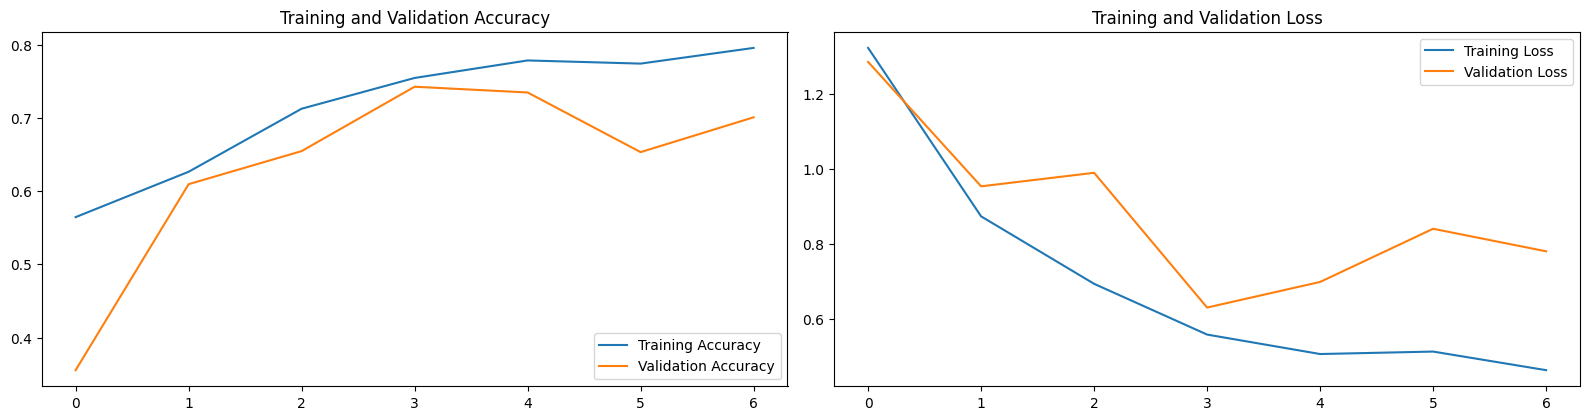

Modèle enregistré sous model_Categorical_modified3.h5


In [45]:
# Afficher les metrics
plot_metrics(history5)
save_model(model_Categorical_modified3, "model_Categorical_modified3")

Modele de classification n°6 : CNN modifié
- Dataset : avec data augmentation (Dataset1)
- Optimizer : Adam
- loss : SparseCategoricalCrossentropy de tensorflow

Modifications :
- Ajout de dropout sur la couche de flatten.
- Ajout d'un earlyStopping dès lors que le modèle n'apprend plus au bout de 5 epochs.
- Ajout de la pondération des classes.
- Suppression de la couche de rescaling
- Ajout de la couche de data augmentation
- Ajout la régularisation L1/L2 pour éviter le surapprentissage

In [46]:
from tensorflow.keras import regularizers
# Modelisation du modèle
model_Categorical_modified4 = Sequential([
    data_augmentation,
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),  # Ajout de Dropout pour réduire le surapprentissage
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.Dense(len(classes), activation='softmax'),
    ])

model_Categorical_modified4.compile(optimizer=Adam(learning_rate=0.001),
                        loss='SparseCategoricalCrossentropy',
                        metrics=['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

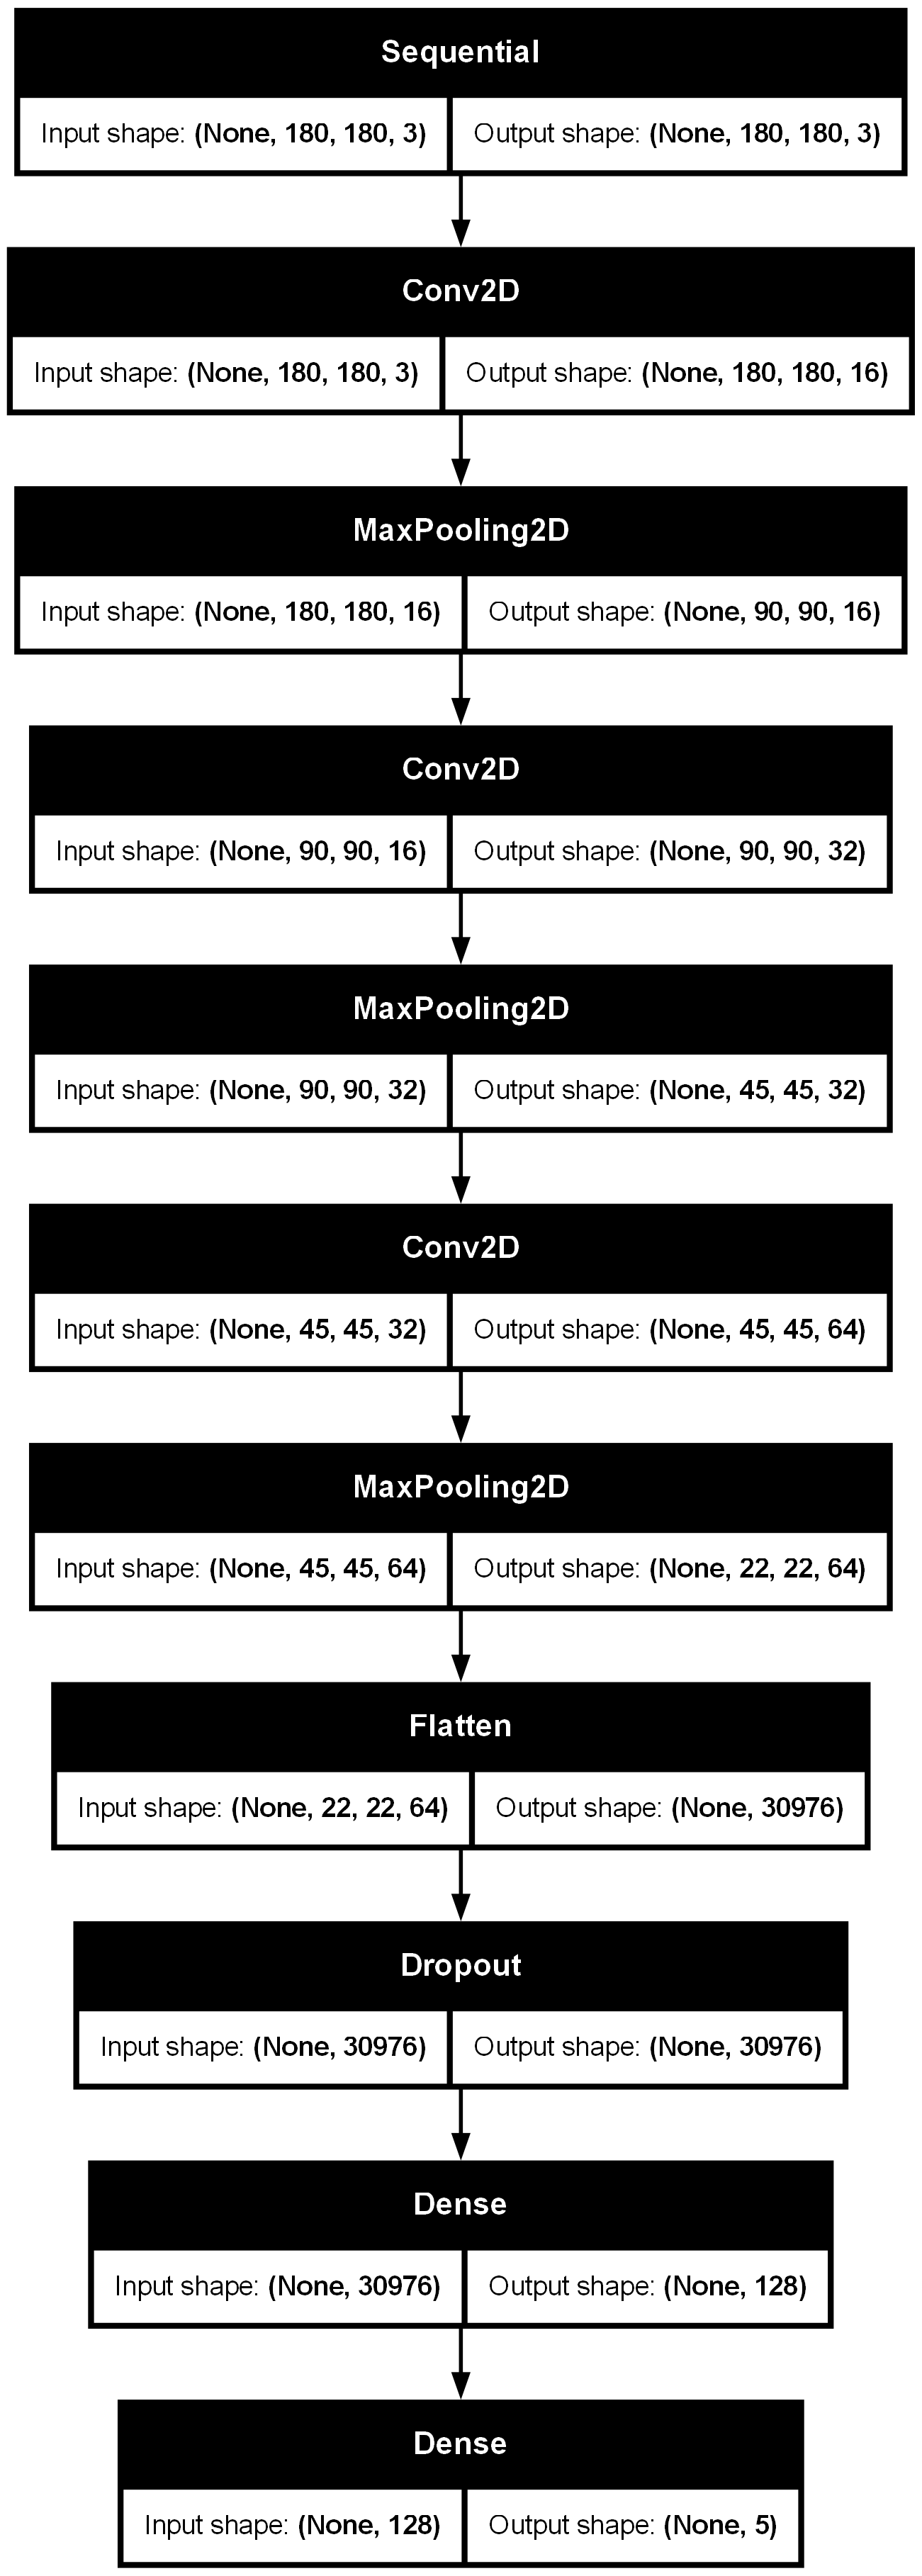

In [47]:
# visualisation de l'architecture du modèle
from keras.utils import plot_model
model_Categorical_modified4.summary()
plot_model(model_Categorical_modified4, to_file='model_Categorical_modified3.png', show_shapes=True)

In [ ]:
# Entraînement du modèle
history6 = model_Categorical_modified4.fit(
    train_set_augmented,
    validation_data=test_set_augmented,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,  # Ajout des poids de classe
)

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 169s 145ms/step - accuracy: 0.4145 - loss: 8.2668 - val_accuracy: 0.5990 - val_loss: 6.0407
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 167s 143ms/step - accuracy: 0.6893 - loss: 5.6358 - val_accuracy: 0.6758 - val_loss: 5.7097
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 164s 141ms/step - accuracy: 0.6998 - loss: 5.5595 - val_accuracy: 0.6930 - val_loss: 5.6365
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 169s 145ms/step - accuracy: 0.7367 - loss: 5.4138 - val_accuracy: 0.7408 - val_loss: 5.4652
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 165s 141ms/step - accuracy: 0.7572 - loss: 5.3385 - val_accuracy: 0.7694 - val_loss: 5.3969
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 165s 141ms/step - accuracy: 0.7790 - loss: 5.2690 - val_accuracy: 0.7472 - val_loss: 5.4474
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 166s 142ms/step - accuracy: 0.7892 - loss: 5.2303 - val_accuracy: 0.7809 - val_loss: 5.4565
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 163s 139ms/step - ac

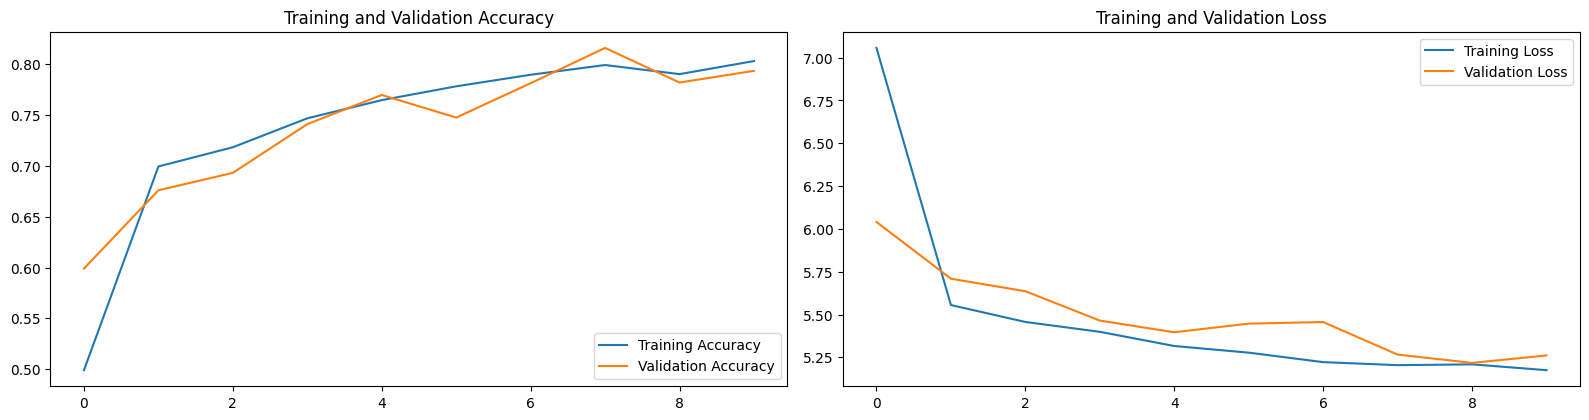

Modèle enregistré sous model_Categorical_modified4.h5


In [61]:
# Afficher les metrics
plot_metrics(history6)
save_model(model_Categorical_modified4, "model_Categorical_modified4")

## Comparaison des modèles

Comparaison des modèles selon les métrics. (val_accuracy, val_loss)

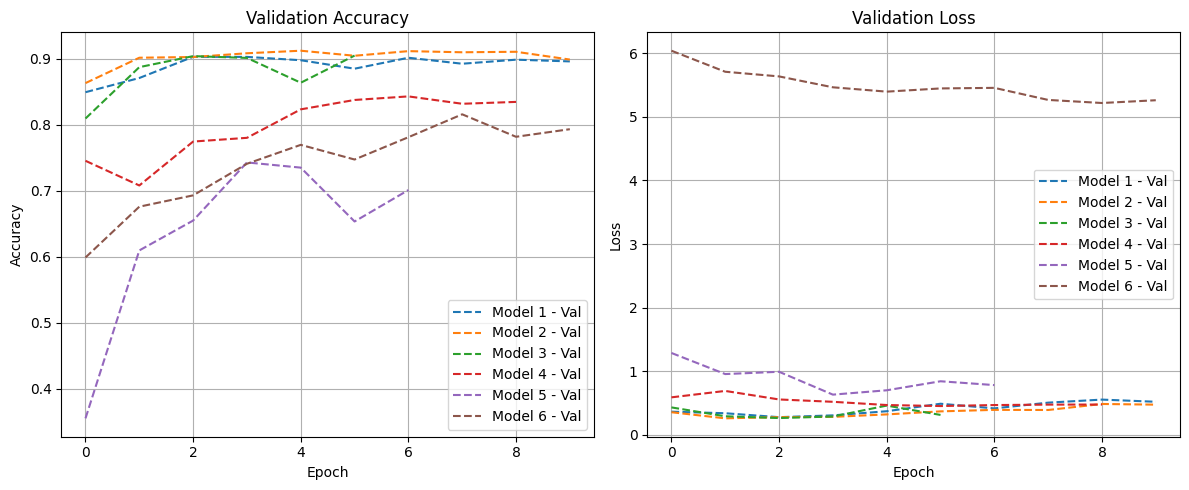

In [104]:
compare_models([history1, history2, history3, history4, history5, history6],
               labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])

---------------------

# Conclusion

Dans le cadre du livrable 1 du projet Option Data Science, nous avons procédé à un nettoyage et une augmentation du jeu de données afin de les rendre exploitables. Une fois cette étape terminée, nous avons étudié et comparé plusieurs modèles de machine learning dans le but de classifier une images entre 5 classes différentes : photo, peinture, shémas, croquis et texte.

Nous avons effectuer du tuning de nos modèles sur les caractéristiques suivantes :
- Ajout de dropout sur la couche de flatten.
- Ajout d'un earlyStopping dès lors que le modèle n'apprend plus au bout de 5 epochs.
- Ajout de la pondération des classes.
- Ajout d'une couche pour data augmentation
- Suppression de la couche de rescaling
- Ajout la régularisation L1/L2 pour éviter le surapprentissage

Après analyse des résultats des différents modèles, le modèle que nous considérons comme le plus performant est 'model_Categorical_modified2' soit notre model 4, au regard de différentes métriques telles que la précision (accuracy) et de la validation loss. 

Ce modèle offre le meilleur compromis entre détection correcte des photos (vrais positifs).

Exemple de prédiction du modèle :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


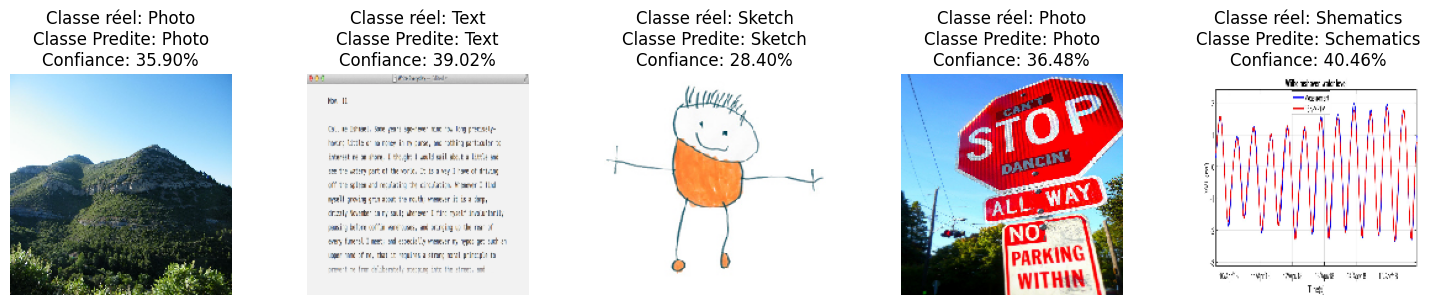

In [102]:
# Afficher les images avec les prédictions
test_images_path = r"C:\Users\mallo\Downloads\Test prédit" # Chemin vers le dossier contenant les images à tester hors du dataset
true_classes = ['Photo', 'Text', 'Sketch', 'Photo', 'Shematics']  # Classes réelles à adapter selon votre cas
display_images_with_predictions(model_Categorical_modified2, test_images_path, true_classes)